# Day 3 - Model Calibration

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy.integrate import odeint
from scipy.optimize import minimize
from IPython.display import display, Math
from scipy.optimize import Bounds

## Defining the model
Let N be the number of tumor cells and assume that this number can increase with a growth rate of $r$ 1/hour until it reaches the environmental carrying capacity of $K$ cells. With these assumptions, the mathematical model is:
\begin{equation}
\frac{dN}{dt}=rN\left(1-\frac{N}{K}\right),
\end{equation}

- $\boldsymbol{\theta}$: vector of model parameters, $\boldsymbol{\theta}=(r,K)$;
- $r$: tumor growth rate;
- $K$: environmental carrying capacity;
- $\boldsymbol{Y}(\boldsymbol{\theta})$: model prediction;

In [2]:
# Let y be the vector of outputs, t the time, and theta the vector of parameters
def control_tumor(y, t, theta):
    return theta[0] * y[0] * (1.0 - y[0] / theta[1])

## Generating the data
We will generate the in silico data using the true model and adding a random perturbation

In [3]:
# Define time interval, parameter value, and initial condition
times = np.arange(0,50,1)
true_r = 0.25
true_K = 60
true_ic = 1
# Solving the ODE model
y = odeint(control_tumor, t=times, y0=true_ic, args=tuple([[true_r,true_K]]))

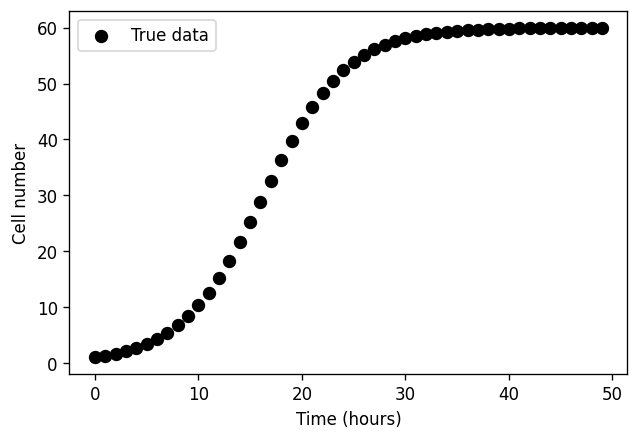

In [4]:
# Plotting the true data
fig, ax = plt.subplots(dpi=120)
plt.scatter(times, y, label='True data', color='black',linewidth=2.0)
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Cell number');
#plt.savefig("just_data.pdf")
plt.show()

In [5]:
#Adding perturbation
true_sigma = 3.6
np.random.seed(2021) # For reproducibility
yobs = np.random.normal(y,true_sigma)
yobs[yobs < 0] = 0

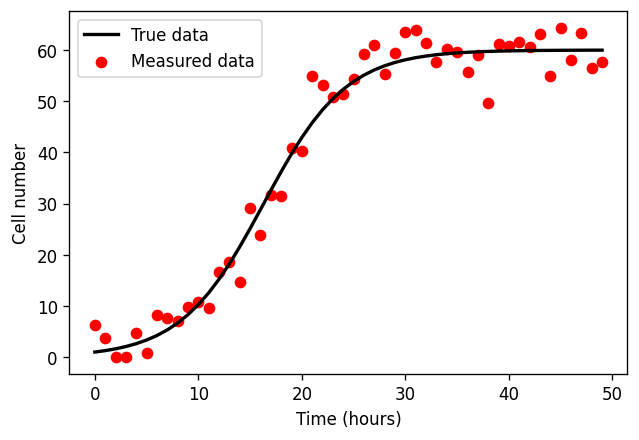

In [6]:
# Plotting the true and observed data
fig, ax = plt.subplots(dpi=120)
plt.plot(times, y, label='True data', color='black',linewidth=2.0)
plt.scatter(times, yobs, label='Measured data', color='red')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Cell number');
#plt.savefig("just_data.pdf")
plt.show()

## Maximum likelihood estimation

Find $\hat{\boldsymbol{\theta}}\in\Theta$, where $\Theta$ is the parameter space, that maximize the likelihood.

It is customary to work with the more manageable log-likelihood function.

\begin{align*}
\hat{\boldsymbol{\theta}}&=\underset{\boldsymbol{\theta}\in\Theta}{\text{argmax}}[\log\pi(\boldsymbol{D}|\boldsymbol{\theta})];\\
&=\underset{\boldsymbol{\theta}\in\Theta}{\text{argmax}}\left[-\frac{1}{2}\sum_{i=1}^{N_t}\left(\log(2\pi)+\log(\sigma^2)+\frac{(D_{i}-Y_i(\boldsymbol{\theta}))^2}{\sigma^2}\right)\right].
\end{align*}

In [7]:
def log_likelihood(theta, times, y):
    cal_r, cal_K, cal_sigma = theta
    model = odeint(control_tumor, t=times, y0=y[0], args=tuple([[cal_r,cal_K]]))
    variance = cal_sigma*cal_sigma
    return -0.5 * np.sum(np.log(2*np.pi)+np.log(variance) + (y - model) ** 2 / variance)

In [8]:
nll = lambda *args: -log_likelihood(*args)

initial = [0.4, 50.0, 0.3]

bounds = Bounds([0.0, 10.0, 0.1], [1.0, 120.0, 30.0])

soln = minimize(nll, initial, args=(times, yobs), bounds=bounds)

In [9]:
soln

      fun: 162.88897335092435
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.51381163e-03,  1.13686828e-05, -5.68434192e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 180
      nit: 22
     njev: 45
   status: 0
  success: True
        x: array([ 0.13893847, 63.53290951,  6.28922051])

In [10]:
ml_r, ml_K, ml_sigma = soln.x

print("Maximum likelihood estimates:")
print("Growth rate = %f" % ml_r)
print("Carrying capacity = %f" % ml_K)
print("Standard deviation = %f" % ml_sigma)

error_r=100*abs(ml_r-true_r)/true_r
error_K=100*abs(ml_K-true_K)/true_K
error_sigma=100*abs(ml_sigma-true_sigma)/true_sigma

print("Growth rate %% error = %f" % error_r)
print("Carrying capacity %% error = %f" % error_K)
print("Standard deviation %% error = %f" % error_sigma)

Maximum likelihood estimates:
Growth rate = 0.138938
Carrying capacity = 63.532910
Standard deviation = 6.289221
Growth rate % error = 44.424610
Carrying capacity % error = 5.888183
Standard deviation % error = 74.700570


In [11]:
y_ml = odeint(control_tumor, t=times, y0=yobs[0], args=tuple([[ml_r,ml_K]]))

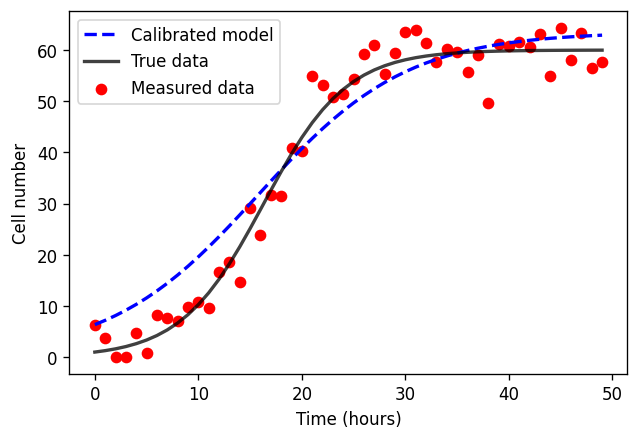

In [12]:
fig, ax = plt.subplots(dpi=120)
plt.plot(times, y_ml, label='Calibrated model', linestyle='dashed', color='blue',linewidth=2.0)
plt.plot(times, y, label='True data', color='black', alpha=0.75,linewidth=2.0)
plt.scatter(times, yobs, label='Measured data', color='red')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Cell number');
#plt.savefig("ml_fit.pdf")
plt.show()

### log-likelihood function

\begin{align*}
\hat{\boldsymbol{\theta}}&=\underset{\boldsymbol{\theta}\in\Theta}{\text{argmax}}[\log\pi(\boldsymbol{D}|\boldsymbol{\theta})];\\
&=\underset{\boldsymbol{\theta}\in\Theta}{\text{argmax}}\left[-\frac{1}{2}\sum_{i=1}^{N_t}\left(\log(2\pi)+\log(\sigma^2)+\frac{(D_{i}-Y_i(\boldsymbol{\theta}))^2}{\sigma^2}\right)\right].
\end{align*}

In [13]:
def log_likelihood_ic(theta, times, y):
    cal_r, cal_K, cal_sigma, cal_ic = theta
    model = odeint(control_tumor, t=times, y0=cal_ic, args=tuple([[cal_r,cal_K]]))
    variance = cal_sigma*cal_sigma
    return -0.5 * np.sum((y - model) ** 2 / variance + np.log(2*np.pi) + np.log(variance))

In [14]:
nll = lambda *args: -log_likelihood_ic(*args)

initial = [0.4, 50.0, 0.3, 5.0]

bounds = Bounds([0.0, 10.0, 0.1, 0.1], [1.0, 120.0, 30.0, 20.0])

soln = minimize(nll, initial, args=(times, yobs), bounds=bounds)

ml_r, ml_K, ml_sigma, ml_ic = soln.x

print("Maximum likelihood estimates:")
print("Growth rate = %f" % ml_r)
print("Carrying capacity = %f" % ml_K)
print("Standard deviation = %f" % ml_sigma)
print("Initial condition = %f" % ml_ic)

error_r=100*abs(ml_r-true_r)/true_r
error_K=100*abs(ml_K-true_K)/true_K
error_sigma=100*abs(ml_sigma-true_sigma)/true_sigma
error_ic=100*abs(ml_ic-true_ic)/true_ic

print("Growth rate %% error = %f" % error_r)
print("Carrying capacity %% error = %f" % error_K)
print("Standard deviation %% error = %f" % error_sigma)
print("Initial condition %% error = %f" % error_ic)

Maximum likelihood estimates:
Growth rate = 0.268103
Carrying capacity = 60.229659
Standard deviation = 3.525973
Initial condition = 0.741894
Growth rate % error = 7.241273
Carrying capacity % error = 0.382764
Standard deviation % error = 2.056298
Initial condition % error = 25.810600


In [15]:
y_ml = odeint(control_tumor, t=times, y0=ml_ic, args=tuple([[ml_r,ml_K]]))

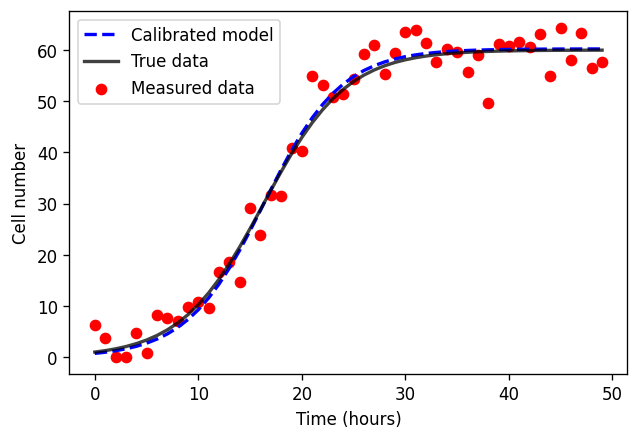

In [16]:
fig, ax = plt.subplots(dpi=120)
plt.plot(times, y_ml, label='Calibrated model', linestyle='dashed', color='blue',linewidth=2.0)
plt.plot(times, y, label='True data', color='black', alpha=0.75,linewidth=2.0)
plt.scatter(times, yobs, label='Measured data', color='red')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Cell number');
#plt.savefig("ml_fit.pdf")
plt.show()

## Bayesian approach
Given events A and B:
\begin{align*}
P(A,B)&=P(A|B)P(B);\\
P(A,B)&=P(B,A);\\
P(B,A)&=P(B|A)P(A);\\
P(A|B)P(B)&=P(B|A)P(A);\\
P(A|B)&=\frac{P(B|A)P(A)}{P(B)};
\end{align*}

Converting to probability densities $\pi$, if $A$ represents the parameter $\boldsymbol{\theta}$ of a model, and $B$ the observational data $\boldsymbol{D}$:
\begin{align*}
\underbrace{\pi(\boldsymbol{\theta}|\boldsymbol{D})}_{\text{posterior}}&=\frac{\overbrace{\pi(\boldsymbol{D}|\boldsymbol{\theta})}^{\text{likelihood}}\overbrace{\pi(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{\pi(\boldsymbol{D})}_{\text{evidence}}};\qquad \pi(\boldsymbol{D})=\int_\Theta\pi(\boldsymbol{D}|\boldsymbol{\theta})\pi(\boldsymbol{\theta})\, \text{d}\theta\\
\pi(\boldsymbol{\theta}|\boldsymbol{D})&\propto\pi(\boldsymbol{D}|\boldsymbol{\theta})\pi(\boldsymbol{\theta});\\
\log\pi(\boldsymbol{\theta}|\boldsymbol{D})&\propto\log\pi(\boldsymbol{D}|\boldsymbol{\theta})+\log\pi(\boldsymbol{\theta});
\end{align*}

In [17]:
def log_prior(theta):
    cal_r, cal_K, cal_sigma, cal_ic = theta
    if 0.0 < cal_r < 1.0 and 10.0 < cal_K < 120.0 and 0.1 < cal_sigma < 30.0 and 0.1 < cal_ic < 20.0:
        return 0.0
    return -np.inf

In [18]:
def log_probability(theta, times, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_ic(theta, times, y)

In [19]:
nwalkers = 10
ndim = 4
pos=np.zeros((nwalkers,ndim))
for i in range(nwalkers):
    pos[i][0] = np.random.uniform(0.0,1.0)
    pos[i][1] = np.random.uniform(10.0,120.0)
    pos[i][2] = np.random.uniform(0.1,30.0)
    pos[i][3] = np.random.uniform(0.1,20.0)

In [20]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(times, yobs))
sampler.run_mcmc(pos, 12500, progress=True);

100%|██████████| 12500/12500 [00:48<00:00, 260.06it/s]


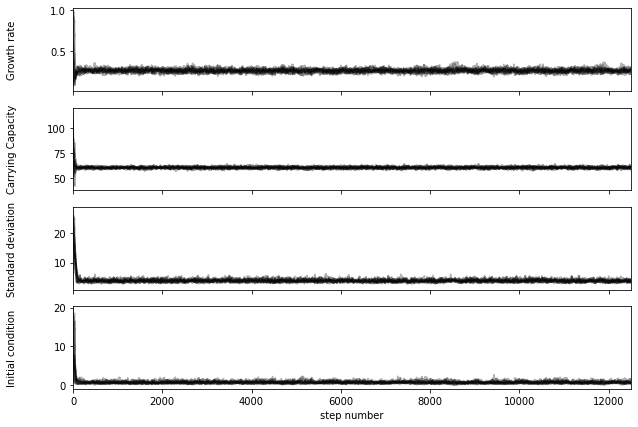

In [22]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Growth rate", "Carrying Capacity", "Standard deviation", "Initial condition"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [23]:
tau = sampler.get_autocorr_time()
print(tau)

[71.66331828 45.34135829 69.92211297 62.06016934]


In [24]:
flat_samples = sampler.get_chain(discard=500, flat=True)
print(flat_samples.shape)

(120000, 4)


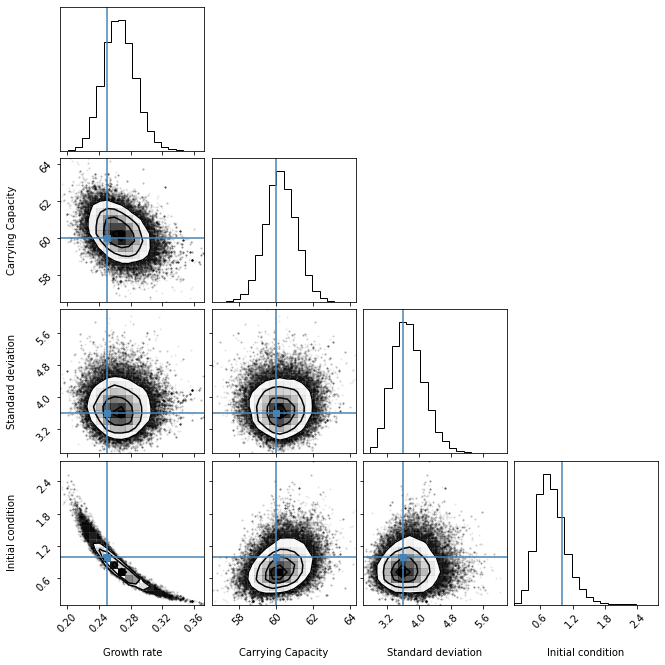

In [25]:
fig = corner.corner(flat_samples, labels=labels, truths=[true_r, true_K, true_sigma, true_ic]);

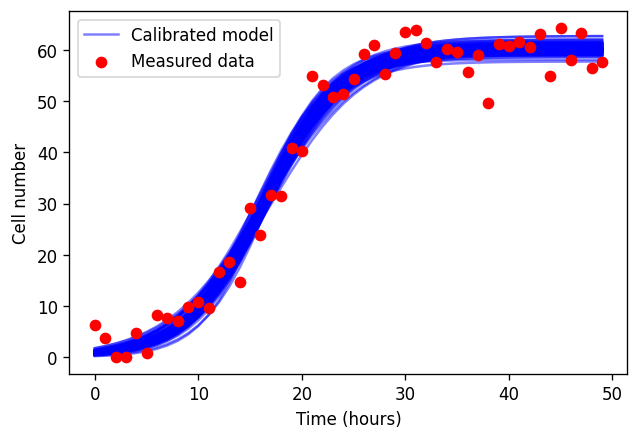

In [26]:
fig, ax = plt.subplots(dpi=120)
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    y_sp = odeint(control_tumor, t=times, y0=sample[3], args=tuple([[sample[0],sample[1]]]))
    plt.plot(times, y_sp, 'blue', alpha=0.5)
plt.plot(times, y_sp, label='Calibrated model', color='blue', alpha=0.5)
plt.scatter(times, yobs, zorder=100, label='Measured data', color='red')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Cell number');
#plt.savefig("bc_fit.pdf")
plt.show()

In [27]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Exercise
Let C be the drug concentration (ng/mL) and assume that: it is consumed by the tumor by a rate $g$. The number of cells will decrease proportionally to the drug concentration at a rate $f$. With these assumptions, the mathematical model is:
\begin{align}
\frac{dN}{dt}&=rN\left(1-\frac{N}{K}\right)-fNC,\\
\frac{dC}{dt}&=-gNC.
\end{align}

- $r$: tumor growth rate;
- $K$: environmental carrying capacity;
- $f$: tumor death rate due to the drug
- $g$: drug consumption rate
- $\theta=(r,K,f,a,b,g)$

In [28]:
#theta = (r,K,f,,g)
def treated_tumor(y, t, theta):
    tumor=theta[0] * y[0] * (1.0 - y[0] / theta[1])-theta[2]*y[0]*y[1]
    drug=-theta[3] * y[0] * y[1]
    return [tumor,drug]

## Generating the data
We will generate the in silico data using the true model and adding a random perturbation

In [29]:
# Define time interval, parameter value, and initial condition
times = np.arange(0,50,0.5)
r = 0.25
K = 60
f = 0.1
g = 0.2
tumor_ic = 1
drug_ic = 5
# Solving the ODE model
y = odeint(treated_tumor, t=times, y0=[tumor_ic,drug_ic], args=tuple([[r,K,f,g]]))

In [30]:
#Adding perturbation
true_sigmaT = 3.6
np.random.seed(2021) # For reproducibility
yobs = np.copy(y)
yobs[:,0] = np.random.normal(y[:,0],true_sigmaT)
true_sigmaD = 0.2
yobs[:,1] = np.random.normal(y[:,1],true_sigmaD)
yobs[yobs < 0] = 0

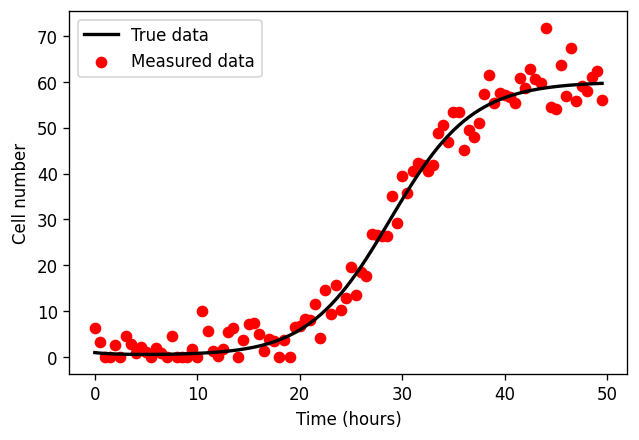

In [31]:
# Plotting the true and observed data
fig, ax = plt.subplots(dpi=120)
plt.plot(times, y[:,0], label='True data', color='black',linewidth=2.0)
plt.scatter(times, yobs[:,0], label='Measured data', color='red')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Cell number');
#plt.savefig("just_data.pdf")
plt.show()

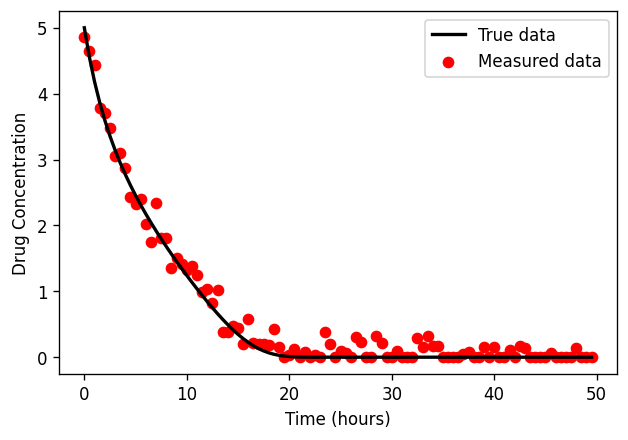

In [32]:
# Plotting the drug solution
fig, ax = plt.subplots(dpi=120)
plt.plot(times, y[:,1], label='True data', color='black',linewidth=2.0)
plt.scatter(times, yobs[:,1], label='Measured data', color='red')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Drug Concentration');
#plt.savefig("just_data.pdf")
plt.show()

## Assumptions
The values of r, K, $\sigma_T$ and tumor initial condition are given as

r = 0.265

K = 60.251

$\sigma_T$ = 3.697

tumor initial condition = 0.779

Calibrate

f, g, $\sigma_D$, and drug initial condition